## Figure 5 Code to Produce Figures

This figure will focus on the presentation of Motif Analysis.

In [1]:
# importing packages
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import pickle
import scipy
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import squareform, pdist
import scipy.io
from scipy import stats
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from difflib import diff_bytes
import seaborn as sns
import h5py
import scipy
import networkx as nx
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)

### Power Analysis for Chain Motif Results

In [2]:
# estimate sample size via power analysis: All Assemblies Together
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
nobs1 = 109
effect = 153 / 100
alpha = 0.05
p = 0.95
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power= p, nobs1= None, ratio= 58 / nobs1, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 17.345


In [3]:
# estimate sample size via power analysis
from statsmodels.stats.power import tt_ind_solve_power
# parameters for power analysis
nobs1_array = [13, 6, 5, 6, 6, 9, 4, 41, 23, 11, 7, 12, 12, 6, 11]
mean_diff_by_difference = [26.24, 29.24, 29.24, 29.24, 29.24, 29.24, 29.24, 3.19, 5.24, 26.33, 10.47, 28.82, 28.66, 27.74, 21.24]
alpha = 0.05
# perform power analysis
for i, n in enumerate(nobs1_array):
    effect = mean_diff_by_difference[i] / 30
    r =  58 / n
    result = tt_ind_solve_power(effect_size = effect, nobs1 = None, alpha = alpha, power = 0.95, ratio = r)
    print(f'Sample Size for Assembly {i + 1}: %.3f' % result)

Sample Size for Assembly 1: 21.151
Sample Size for Assembly 2: 15.277
Sample Size for Assembly 3: 15.012
Sample Size for Assembly 4: 15.277
Sample Size for Assembly 5: 15.277
Sample Size for Assembly 6: 16.064
Sample Size for Assembly 7: 14.747
Sample Size for Assembly 8: 1962.506
Sample Size for Assembly 9: 595.391
Sample Size for Assembly 10: 20.381
Sample Size for Assembly 11: 119.771
Sample Size for Assembly 12: 17.330
Sample Size for Assembly 13: 17.520
Sample Size for Assembly 14: 16.953
Sample Size for Assembly 15: 31.150


### Explorative Analysis of Connectivity Matrix

In [4]:
ground_truth_connectome_v1dd_1 = np.load("ground_truth_connectome_v1dd_1.npy")
ground_truth_connectome_v1dd_1.shape

print("Total connections", np.sum(ground_truth_connectome_v1dd_1))
ground_truth_connectome_v1dd_1

Total connections 171492.0


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  2.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 16.],
       [ 0.,  0.,  0., ...,  0.,  4.,  0.]])

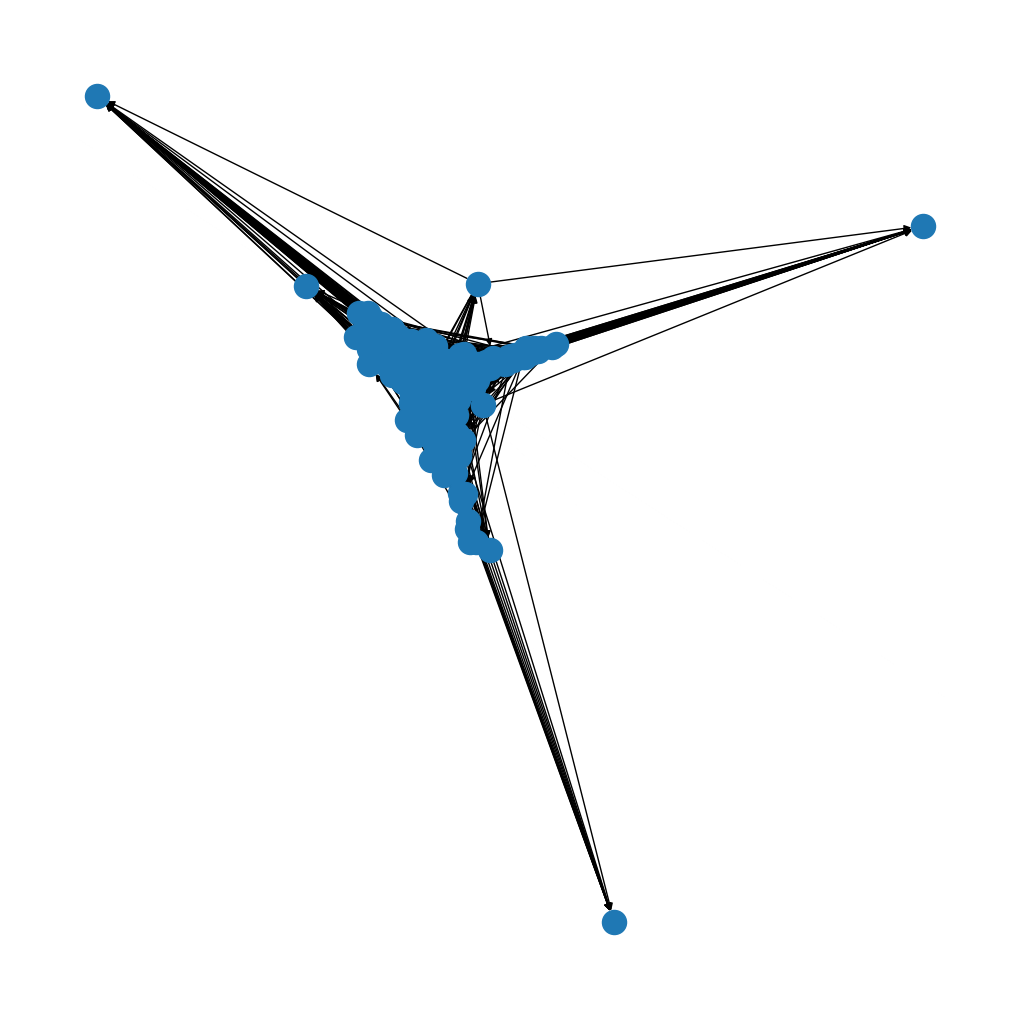

In [5]:
pyr_graph = nx.from_numpy_array(ground_truth_connectome_v1dd_1, create_using=nx.DiGraph)
nx.draw(pyr_graph)

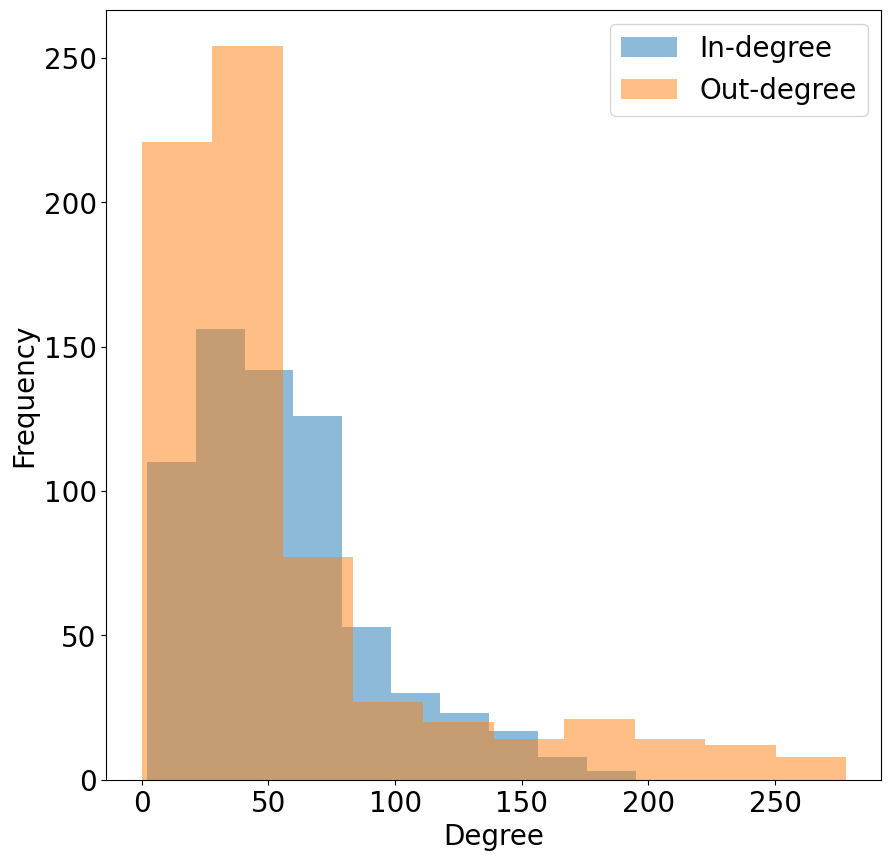

In [6]:
# Degree distribution
in_degrees = dict(pyr_graph.in_degree())
out_degrees = dict(pyr_graph.out_degree())

plt.hist(list(in_degrees.values()), bins=10, alpha=0.5, label='In-degree')
plt.hist(list(out_degrees.values()), bins=10, alpha=0.5, label='Out-degree')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# Clustering coefficient
clustering_coefficient = nx.average_clustering(pyr_graph)
print("Clustering coefficient:", clustering_coefficient)

Clustering coefficient: 0.2523980727735077


In [8]:
# Strongly connected components
""" https://networkx.org/documentation/stable/_modules/networkx/algorithms/components/strongly_connected.html#strongly_connected_components
Parameters
    ----------
    G : NetworkX Graph
        A directed graph.

    Returns
    -------
    comp : generator of sets
        A generator of sets of nodes, one for each strongly connected
        component of G.
"""
strongly_connected_components = list(nx.strongly_connected_components(pyr_graph))
num_strongly_connected_components = len(strongly_connected_components)
print("Number of strongly connected components:", num_strongly_connected_components)

sizes_strongly_connected_components = [len(component) for component in strongly_connected_components]
print("Sizes of strongly connected components:", sizes_strongly_connected_components)

Number of strongly connected components: 4
Sizes of strongly connected components: [1, 1, 1, 665]


### First-Order Connectivity Analysis with LSMMData Data Wrangler

Previous code will be useful here, and after finishing this section we can delete the previous code (most likely)

In [3]:
# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       76  293733  864691132616354625         858877         700030   
4       85  307952  864691132999200949         867646         840563   
..     ...     ...                 ...            ...            ...   
847   8764  371302  864691132849454803         958050         629957   
848   8769  385115  864691132679146333         975354         850418   
849   8773  383491  864691132763271347         928872         797418   
850   8790  351167  864691132579592205         927863         548865   
851   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [4]:
def calc_ground_truth(pre_cells, synapse, post_cells, use_sizes=False):
    total_synapse_count = 0
    pre_cell_pt_index = pre_cells['pt_root_id']
    post_cell_pt_index = post_cells['pt_root_id']
    synapses = synapse[(synapse['pre_pt_root_id'].isin(pre_cells['pt_root_id'])) & (synapse['post_pt_root_id'].isin(post_cells['pt_root_id']))]
    pre_cell_pt_index = pre_cell_pt_index.to_list()
    post_cell_pt_index = post_cell_pt_index.to_list()
 
    synapse_connectome = np.zeros((len(pre_cells), len(post_cells)))
    for synapse in tqdm(range(len(synapses))):
        preidx = pre_cell_pt_index.index(synapses.iloc[synapse]['pre_pt_root_id'])
        postidx = post_cell_pt_index.index(synapses.iloc[synapse]['post_pt_root_id'])
        if use_sizes:
            synapse_connectome[preidx,postidx] += synapses.iloc[synapse]['size']
        else:
            synapse_connectome[preidx,postidx] += 1
        total_synapse_count += 1
    print(total_synapse_count)
    return synapse_connectome

In [5]:
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])

pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']
print("Connectome Index.  Should be 41:", mappings['pt_root_id_to_connectome_index'][pt_root_id])

     index      id          pt_root_id  pt_position_x  pt_position_y  \
0        9  293764  864691132625300120         878665         697702   
1       41  295576  864691132710501931         842193         737122   
2       62  278405  864691132830575876         737898         601710   
3       76  293733  864691132616354625         858877         700030   
4       85  307952  864691132999200949         867646         840563   
..     ...     ...                 ...            ...            ...   
847   8764  371302  864691132849454803         958050         629957   
848   8769  385115  864691132679146333         975354         850418   
849   8773  383491  864691132763271347         928872         797418   
850   8790  351167  864691132579592205         927863         548865   
851   8794  277788  864691132653866455         853833         547235   

     pt_position_z classification_system cell_type status_axon  \
0           245475            excitatory        4P    extended   
1  

In [6]:
mappings.keys()

dict_keys(['functional_indexes_by_assembly', 'assemblies_by_functional_index', 'pt_root_id_to_connectome_index', 'connectome_index_to_root_id', 'roi_id_to_pt_root_id', 'functional_index_to_roi_id', 'assemblies_by_roi_id', 'assemblies_by_pt_root_id', 'assemblies_by_connectome_index'])

In [7]:
ground_truth_connectome_v1dd = calc_ground_truth(tables['structural']['pre_cell'], tables['structural']['synapse'], tables['structural']['post_cell'])
ground_truth_connectome_v1dd

100%|██████████| 163052/163052 [00:12<00:00, 12543.63it/s]


163052


array([[16.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 33.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 29., ...,  0.,  0.,  1.],
       ...,
       [ 0.,  0.,  0., ..., 28.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1., 46.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 15.]])

In [8]:
print(mappings['assemblies_by_connectome_index'])
print(len(mappings['assemblies_by_connectome_index']))
assembly_connectome_index = []
no_assembly_connectome_index = []
for key, val in mappings['assemblies_by_connectome_index'].items():
    if val == ['No A']:
        no_assembly_connectome_index.append(key)
    else:
        assembly_connectome_index.append(key)

print(assembly_connectome_index)
print(len(assembly_connectome_index))
print(no_assembly_connectome_index)
print(len(no_assembly_connectome_index))

{377: ['A 1'], 303: ['A 1', 'A 3', 'A 4', 'A 5', 'A 7', 'A 8'], 10: ['A 1'], 630: ['A 1', 'A 5', 'A 7', 'A 10'], 458: ['A 1', 'A 3'], 126: ['A 1'], 749: ['A 1', 'A 4', 'A 7', 'A 8'], 162: ['A 1', 'A 4', 'A 7', 'A 8'], 225: ['A 1', 'A 2', 'A 8'], 535: ['A 1', 'A 3'], 701: ['A 1'], 429: ['A 1', 'A 3', 'A 5'], 663: ['A 1', 'A 2', 'A 3'], 353: ['A 1', 'A 6'], 425: ['A 1'], 125: ['A 1', 'A 4'], 201: ['A 1', 'A 6'], 27: ['A 1', 'A 3', 'A 4'], 837: ['A 1', 'A 2'], 329: ['A 1', 'A 6'], 763: ['A 1', 'A 3', 'A 8'], 68: ['A 2', 'A 11'], 109: ['A 2'], 454: ['A 2'], 730: ['A 2', 'A 10'], 800: ['A 2', 'A 4', 'A 5'], 391: ['A 2', 'A 10'], 304: ['A 3'], 229: ['A 3', 'A 7', 'A 8'], 374: ['A 3'], 52: ['A 4'], 659: ['A 4'], 806: ['A 4', 'A 5', 'A 7', 'A 8'], 161: ['A 4', 'A 5', 'A 7', 'A 8'], 715: ['A 5', 'A 7'], 243: ['A 5'], 845: ['A 6'], 563: ['A 9', 'A 12'], 633: ['A 9'], 73: ['A 10'], 728: ['A 10'], 710: ['A 13', 'A 15'], 298: ['A 14'], 597: ['No A'], 255: ['No A'], 379: ['No A'], 764: ['No A'], 770

In [9]:
### Start with Fist-Order Connections
# Grab Connectome with root ids, develop counts of first-order connections for assembly and no assembly set

assembly_first_order_connections = []
c_in_assembly = 0
non_assembly_first_order_connections = []
c_no_assembly = 0
for i in range(len(ground_truth_connectome_v1dd[0])):
    if i in assembly_connectome_index:
        c_in_assembly += 1
        assembly_first_order_connections.append(np.sum(ground_truth_connectome_v1dd[i,:]))
    elif i in no_assembly_connectome_index:
        c_no_assembly += 1
        non_assembly_first_order_connections.append(np.sum(ground_truth_connectome_v1dd[i,:]))

print("Number in Assembly Set:", c_in_assembly)
print("Number in No Assembly Set:", c_no_assembly)
print("Mean First-Order Connections of Assembly Set:", np.mean(assembly_first_order_connections))
print("Mean First-Order Connections of No Assembly Set:", np.mean(non_assembly_first_order_connections))

Number in Assembly Set: 43
Number in No Assembly Set: 12
Mean First-Order Connections of Assembly Set: 90.34883720930233
Mean First-Order Connections of No Assembly Set: 76.91666666666667


In [10]:
np.median(assembly_first_order_connections), np.median(non_assembly_first_order_connections)

(84.0, 81.5)

/Users/jawagnercarena/opt/anaconda3/envs/cs109a/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jawagnercarena/opt/anaconda3/envs/cs109a/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


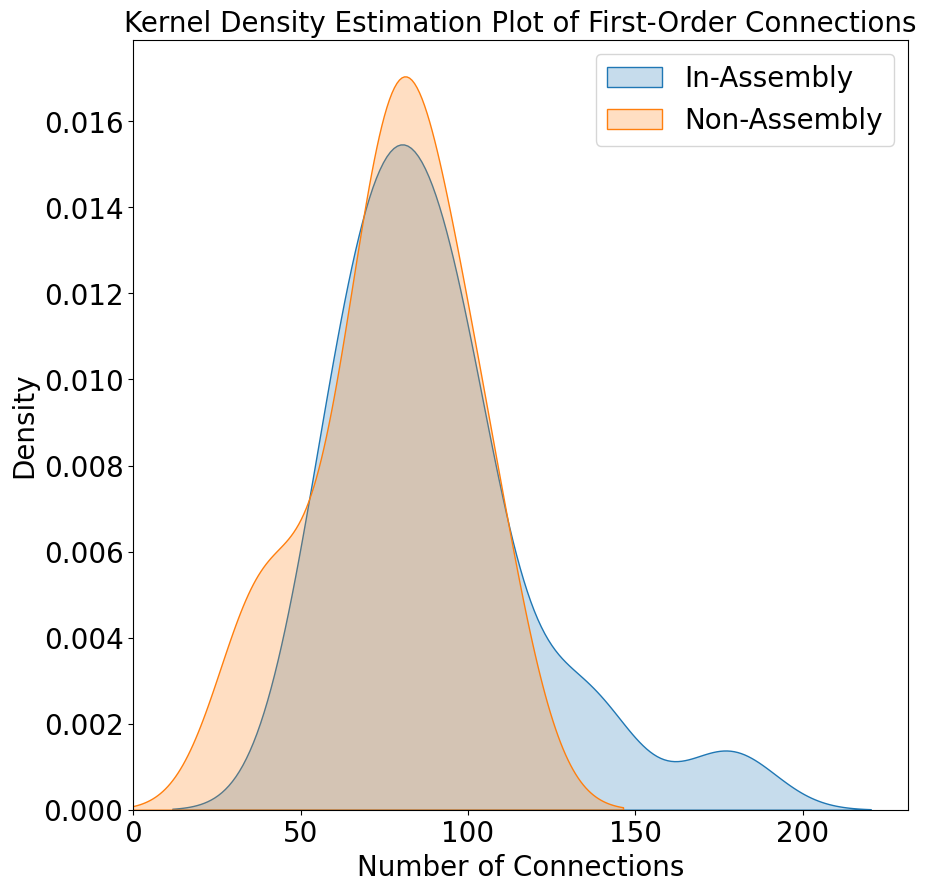

In [11]:
### See the general distribution of the assembly counts to justify the statistical test
sns.kdeplot(assembly_first_order_connections, fill = True, label = 'In-Assembly')
sns.kdeplot(non_assembly_first_order_connections, fill = True, label = 'Non-Assembly')
plt.legend()
plt.title('Kernel Density Estimation Plot of First-Order Connections', size = 20)
plt.xlabel('Number of Connections', size = 20)
plt.ylabel('Density', size = 20)
plt.xlim(0)
plt.show()
#plt.savefig("Kernel_Density_Estimator_Connections_Distributions.png", dpi = 1200)

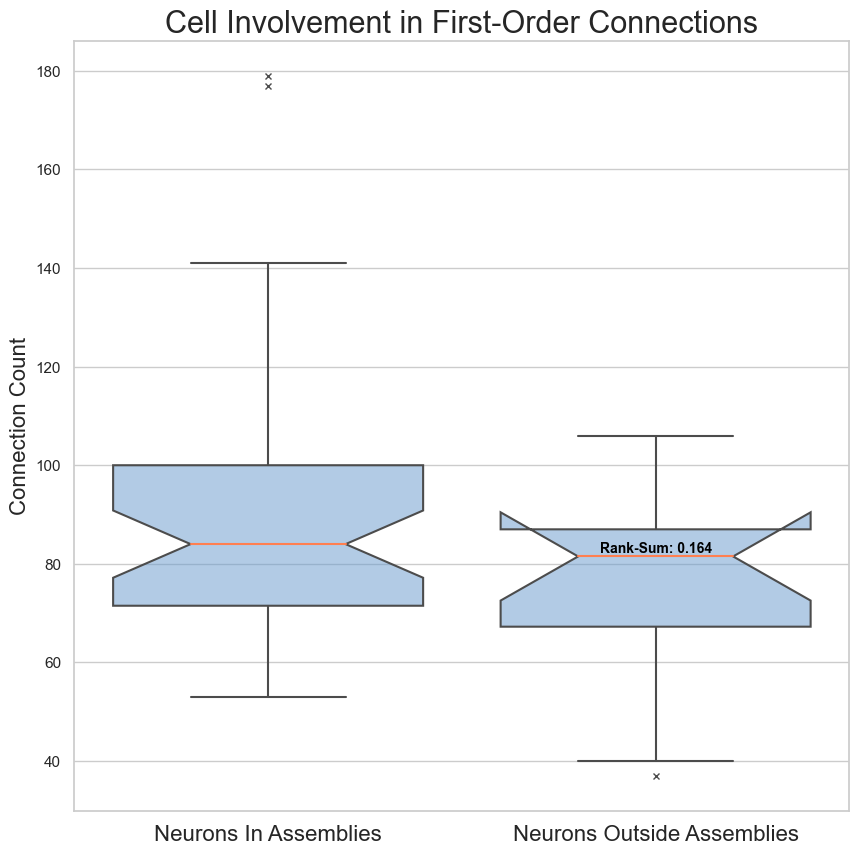

In [12]:
### Produce Box-Plots and Statistical Test of Distribution

all_arr = [np.array(assembly_first_order_connections).flatten(),
            np.array(non_assembly_first_order_connections).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Neurons In Assemblies", "Neurons Outside Assemblies"], size = 16)
ax.set_title('Cell Involvement in First-Order Connections', size = 22)
ax.set_ylabel('Connection Count', size = 16)

medians = np.array(
    [np.median(np.array(assembly_first_order_connections).flatten()),
     np.median(np.array(non_assembly_first_order_connections).flatten())]
)

vertical_offset = medians * 0.01 # offset from median for display
p_values = [np.nan,
            'Rank-Sum: {:.3g}'.format(stats.ranksums(np.array(assembly_first_order_connections).flatten(), np.array(non_assembly_first_order_connections).flatten(), alternative='greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size='small', color='black', weight='semibold')

#plt.savefig('first_order_boxplot.png', dpi = 1200)
plt.show()

### Dot-Motif Chain Motif Analysis

In [2]:
# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

In [3]:
def invert_dict(original_dict):
    inverted_dict = {}
    for key, items in original_dict.items():
        for item in items:
            if item not in inverted_dict:
                inverted_dict[item] = [key]
            else:
                inverted_dict[item].append(key)
    return inverted_dict

In [4]:
assemblies_by_coregistered = invert_dict(mappings['assemblies_by_connectome_index'])

counter = len({item for val in assemblies_by_coregistered.values() if val is not None for item in val})

print("Total Number of Neurons that are Coregistered & Assigned to Assemblies:", counter)
print("Total Number of Neurons that are Coregistered & Assigned to No Assemblies:", len(assemblies_by_coregistered['No A']))
for key, val in assemblies_by_coregistered.items():
    print(key,":", val)
#assemblies_by_coregistered

Total Number of Neurons that are Coregistered & Assigned to Assemblies: 55
Total Number of Neurons that are Coregistered & Assigned to No Assemblies: 12
A 1 : [377, 303, 10, 630, 458, 126, 749, 162, 225, 535, 701, 429, 663, 353, 425, 125, 201, 27, 837, 329, 763]
A 3 : [303, 458, 535, 429, 663, 27, 763, 304, 229, 374]
A 4 : [303, 749, 162, 125, 27, 800, 52, 659, 806, 161]
A 5 : [303, 630, 429, 800, 806, 161, 715, 243]
A 7 : [303, 630, 749, 162, 229, 806, 161, 715]
A 8 : [303, 749, 162, 225, 763, 229, 806, 161]
A 10 : [630, 730, 391, 73, 728]
A 2 : [225, 663, 837, 68, 109, 454, 730, 800, 391]
A 6 : [353, 201, 329, 845]
A 11 : [68]
A 9 : [563, 633]
A 12 : [563]
A 13 : [710]
A 15 : [710]
A 14 : [298]
No A : [597, 255, 379, 764, 770, 234, 34, 419, 484, 799, 808, 89]


In [5]:
### Check that this is the most updated dot motif file
three_chain_dot_motif_result = pd.read_pickle("./dot_motif_results/pyc_three_chain_results.pickle")

max_idx = max([max(d.values()) for d in three_chain_dot_motif_result])
max_idx

851

In [6]:
def enumerate_chain_motifs(dot_motif_dict, A_by_coregistered, assemblies: bool):
    # initialize dataframe
    dot_motif_dict_df = pd.DataFrame(dot_motif_dict)

    # initialize data frames for keeping track of chain motifs
    chains_w_A = pd.DataFrame()
    chains_w_B = pd.DataFrame()
    chains_w_C = pd.DataFrame()

    if assemblies:
        connectome_ids = {id for assignment in A_by_coregistered if assignment != 'No A' for id in A_by_coregistered[assignment]}
        connectome_ids = np.sort(list(connectome_ids))
    else:
        connectome_ids = A_by_coregistered['No A']

    for connectome_id in connectome_ids:
        # we check if the first or third position is an connectome_id assigned to an assembly
        mask = dot_motif_dict_df['A'] == connectome_id
        A = dot_motif_dict_df[mask]
        chains_w_A = pd.concat([chains_w_A, A], ignore_index=True)

        mask = dot_motif_dict_df['B'] == connectome_id
        B = dot_motif_dict_df[mask]
        chains_w_B = pd.concat([chains_w_B, B], ignore_index=True)

        mask = dot_motif_dict_df['C'] == connectome_id
        C = dot_motif_dict_df[mask]
        chains_w_C = pd.concat([chains_w_C, C], ignore_index=True)
    
    # keep track of assigned cell ids
    chains_w_A['assembly_cell_id'] = chains_w_A['A']
    # chains_w_B['assembly_cell_id'] = chains_w_B['B']
    chains_w_C['assembly_cell_id'] = chains_w_C['C']

    # combine all information to one data frame
    all_motifs = pd.DataFrame(pd.concat([chains_w_A,chains_w_B,chains_w_C]))
    return all_motifs

In [7]:
len(three_chain_dot_motif_result)

6052393

In [8]:
assembly_motifs = enumerate_chain_motifs(three_chain_dot_motif_result, assemblies_by_coregistered, assemblies = True)
assembly_motifs

,A,B,C,assembly_cell_id
0,10,3,5,10.0
1,10,3,11,10.0
2,10,3,13,10.0
3,10,3,29,10.0
4,10,3,30,10.0
...,...,...,...,...
391733,850,669,845,845.0
391734,850,841,845,845.0
391735,851,595,845,845.0
391736,851,669,845,845.0


In [9]:
no_assembly_motifs = enumerate_chain_motifs(three_chain_dot_motif_result, assemblies_by_coregistered, assemblies = False)
no_assembly_motifs

,A,B,C,assembly_cell_id
0,597,2,6,597.0
1,597,2,35,597.0
2,597,2,36,597.0
3,597,2,44,597.0
4,597,2,45,597.0
...,...,...,...,...
105898,850,455,89,89.0
105899,850,574,89,89.0
105900,850,668,89,89.0
105901,851,595,89,89.0


assembly_cell_id
377.0    26205
126.0    25497
52.0     24663
225.0    23639
563.0    23401
535.0    20571
728.0    19986
10.0     19296
458.0    19222
715.0    19136
630.0    19085
162.0    19030
429.0    18867
730.0    18805
749.0    18350
125.0    18149
454.0    18119
763.0    18110
201.0    18073
663.0    17851
109.0    16782
425.0    16705
806.0    16699
800.0    14561
304.0    14436
27.0     14387
710.0    14149
391.0    14058
161.0    13968
229.0    13911
659.0    13821
68.0     13498
303.0    12942
329.0    12848
73.0     12659
845.0    12475
701.0    12466
298.0    12121
633.0    10965
837.0    10925
243.0    10292
353.0     9671
374.0     6890
Name: count, dtype: int64
assembly_cell_id
255.0    20371
234.0    19525
764.0    17759
34.0     17453
770.0    16521
379.0    16370
484.0    15848
808.0    13647
89.0     12342
597.0    12337
419.0    11932
799.0     8390
Name: count, dtype: int64


/Users/jawagnercarena/opt/anaconda3/envs/cs109a/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jawagnercarena/opt/anaconda3/envs/cs109a/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


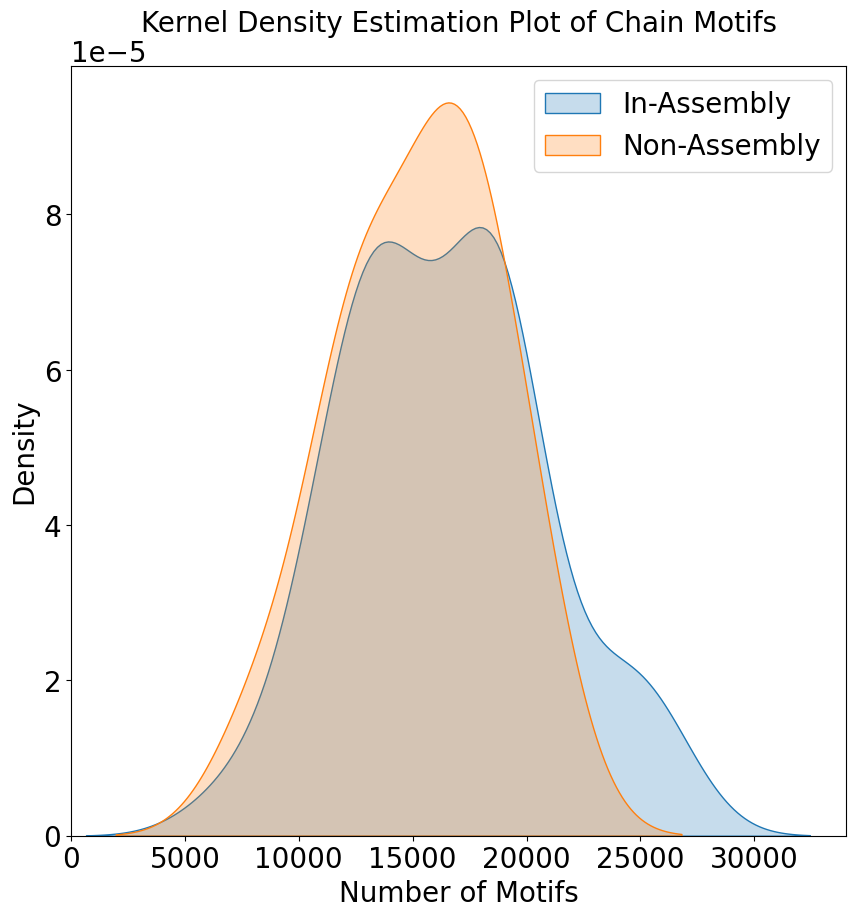

In [10]:
### define the assembly counts
assembly_counts = assembly_motifs['assembly_cell_id'].value_counts()
print(assembly_counts)

### define the non_assembly counts
non_assembly_counts = no_assembly_motifs['assembly_cell_id'].value_counts()
print(non_assembly_counts)

### See the general distribution of the assembly counts to justify the statistical test
## In-assemlby test is bi-modal, so t-test wouldn't be the best to use 
sns.kdeplot(assembly_counts, fill = True, label = 'In-Assembly')
sns.kdeplot(non_assembly_counts, fill = True, label = 'Non-Assembly')
plt.legend()
plt.title('Kernel Density Estimation Plot of Chain Motifs', size = 20)
plt.xlabel('Number of Motifs', size = 20)
plt.ylabel('Density', size = 20)
plt.xlim(0)
plt.show()

In [11]:
print(np.mean(assembly_counts), np.mean(non_assembly_counts))
print(np.median(assembly_counts), np.median(non_assembly_counts))
print(np.std(assembly_counts), np.std(non_assembly_counts))

16448.46511627907 15207.916666666666
16705.0 16109.0
4355.905920508156 3371.882695130752


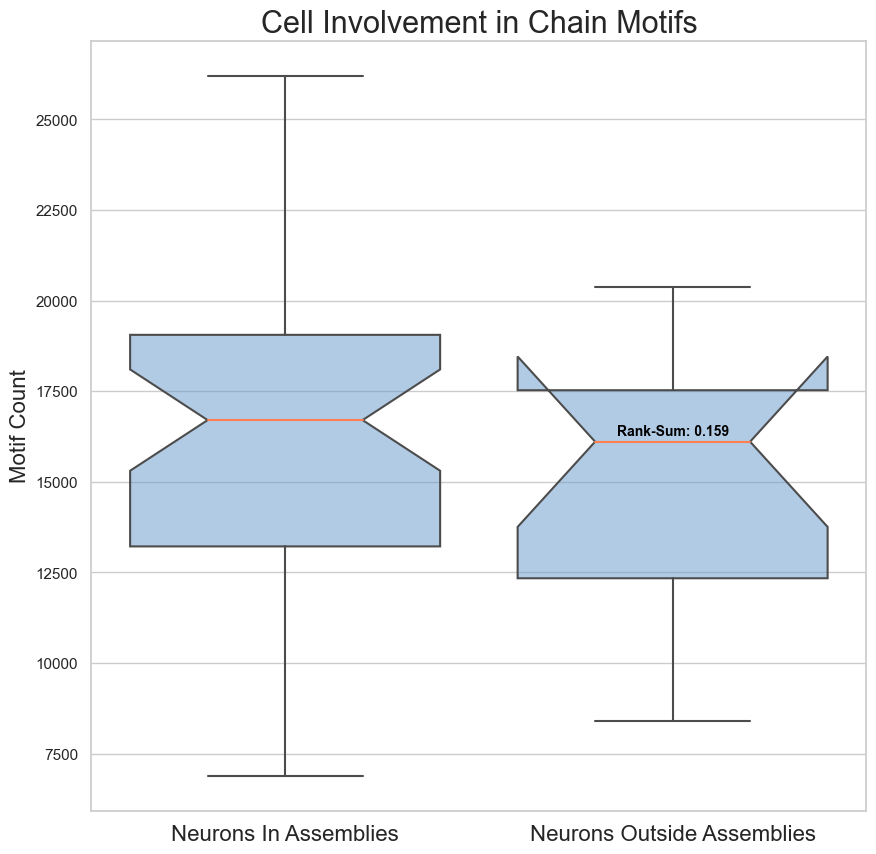

In [12]:
all_arr = [np.array(assembly_counts).flatten(),
            np.array(non_assembly_counts).flatten()]
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=all_arr,
                notch=True, showcaps=True,
                flierprops={"marker": "x"},
                boxprops={"facecolor": (.4, .6, .8, .5)},
                medianprops={"color": "coral"},
            )
ax.set_xticklabels(["Neurons In Assemblies", "Neurons Outside Assemblies"], size = 16)
ax.set_title('Cell Involvement in Chain Motifs', size = 22)
ax.set_ylabel('Motif Count', size = 16)

medians = np.array(
    [np.median(np.array(assembly_counts).flatten()),
     np.median(np.array(non_assembly_counts).flatten())]
)

vertical_offset = medians * 0.01 # offset from median for display
p_values = [np.nan,
            'Rank-Sum: {:.3g}'.format(stats.ranksums(np.array(assembly_counts).flatten(), np.array(non_assembly_counts).flatten(), 'greater').pvalue, 5)]

for xtick in ax.get_xticks():
    if xtick != 0:
        ax.text(xtick, medians[xtick] + vertical_offset[xtick], p_values[xtick], 
                horizontalalignment='center', size='small', color='black', weight='semibold')

#plt.savefig('dot_motif_three_chain_boxplot.png', dpi = 1200)
plt.show()

In [13]:
mw_p_value = stats.mannwhitneyu(np.array(assembly_counts).flatten(), np.array(non_assembly_counts).flatten()).pvalue
mw_p_value

0.3229782234150702

### Stefan's Implementation of Chain Count Participation

In [2]:
def motif_produce_boxplot(chain_results, just_pyramidal: bool, chain_num: int):
    coregistered_cell_indexes = mappings['assemblies_by_connectome_index'].keys()
    no_a_cell_indexes = mappings['connectome_indexes_by_assembly']['No A']

    # Get chain participation
    chain_participation_by_coregistered_cell = {}
    for index in coregistered_cell_indexes:
        # this only works because the index cannot appear in the same chain more than once
        chain_participation_by_coregistered_cell[index] = np.where(chain_results == index)[0].size

    pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))

    # Pool cells which are in assemblies
    pooled_assembly_cell_participation = []
    for index in pooled_assembly_indexes:
        pooled_assembly_cell_participation.append(chain_participation_by_coregistered_cell[index])

    # Pool cells which are not in assemblies
    no_a_cell_participation = []
    for index in no_a_cell_indexes:
        no_a_cell_participation.append(chain_participation_by_coregistered_cell[index])

    plt.figure()
    plt.box
    plt.boxplot([pooled_assembly_cell_participation, no_a_cell_participation])
    if just_pyramidal:
        title = f"Pyramidal Cells with Chain Length of {chain_num}"
    else:
        title = f"All Cells with Chain Length of {chain_num}"
    plt.title(title)
    #plt.savefig('pyr_cell_chain_participation.png')

    print('A', pooled_assembly_cell_participation)
    print('No A', no_a_cell_participation)
    print('Done')
    print('Rank-Sum Test:', stats.ranksums(np.array(pooled_assembly_cell_participation).flatten(), np.array(no_a_cell_participation).flatten(), 'greater').pvalue)

In [3]:
all_cells_three_chain_results_array = np.load("dot_motif_results/all_cell_three_chain_results_array.npy")
pyr_cells_three_chain_results_array = np.load("dot_motif_results/pyr_cell_three_chain_results_array.npy")
all_cells_four_chain_results_array = np.load("dot_motif_results/all_cell_four_chain_results_array.npy")
pyr_cells_four_chain_results_array = np.load("dot_motif_results/pyr_cell_four_chain_results_array.npy")

In [4]:
# Import Stefan's Library for Data Management of V1DD
from LSMMData.data_management import LSMMData

with open('v1dd_wrangler_input_dict.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings

A [17225, 23393, 16374, 20828, 27482, 17062, 17207, 17048, 23615, 19918, 20131, 14157, 22590, 15607, 17088, 31449, 33525, 14567, 15669, 13060, 21945, 16874, 21946, 22744, 15790, 23672, 14985, 15240, 24755, 23006, 31538, 10623, 16342, 23084, 20079, 12522, 12079, 23765, 7637, 35135, 22019, 22103, 33155]
No A [13847, 25336, 19646, 21742, 19608, 24500, 21411, 14024, 18407, 9280, 16332, 14471]
Done
Rank-Sum Test: 0.16399587359726192


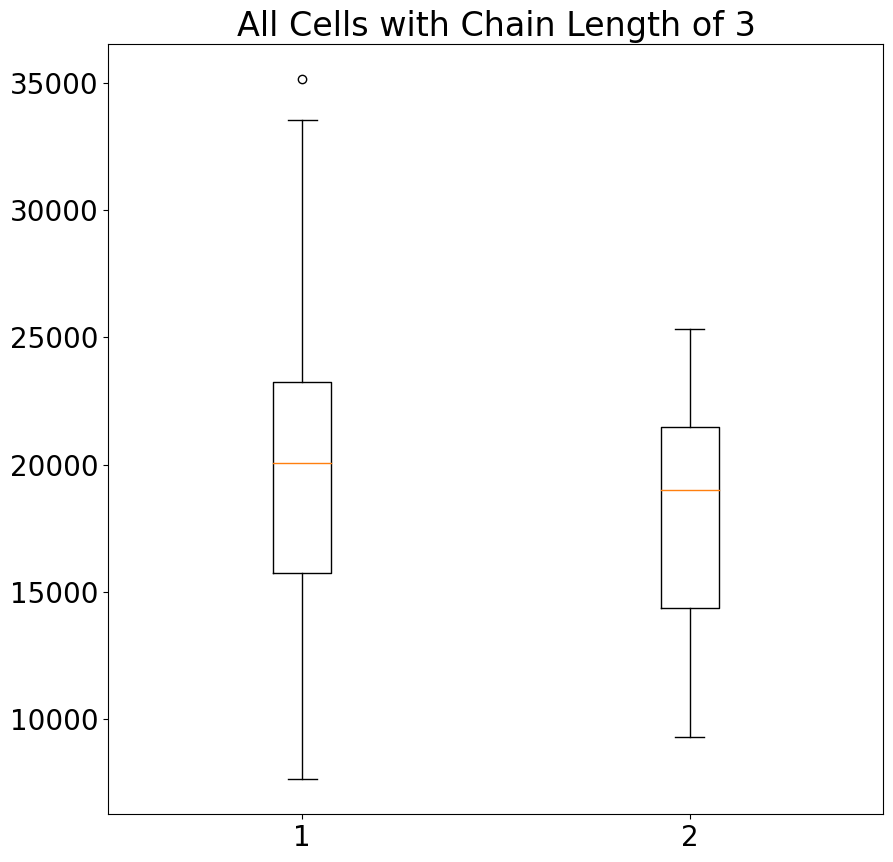

In [5]:
motif_produce_boxplot(all_cells_three_chain_results_array, just_pyramidal = False, chain_num = 3)

A [249, 324, 0, 0, 0, 131, 0, 167, 59, 0, 70, 623, 689, 137, 449, 0, 666, 0, 277, 0, 70, 0, 178, 419, 237, 0, 0, 254, 0, 0, 246, 110, 505, 0, 765, 0, 435, 0, 105, 34, 0, 292, 41]
No A [0, 416, 195, 0, 0, 145, 48, 195, 0, 0, 0, 737]
Done
Rank-Sum Test: 0.2772682908352456


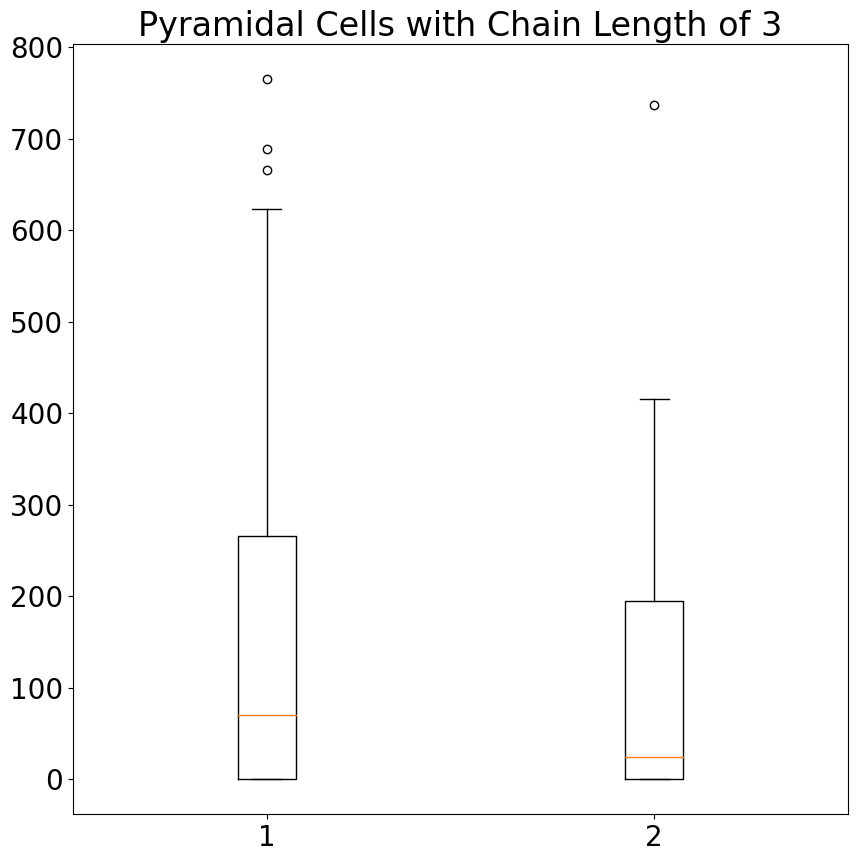

In [6]:
motif_produce_boxplot(pyr_cells_three_chain_results_array, just_pyramidal = True, chain_num = 3)

A [2055601, 2996962, 1941440, 2581046, 3628956, 2047685, 2040804, 2026291, 3048503, 2458431, 2479718, 1622369, 2847331, 1827314, 2044438, 4311873, 4620761, 1673317, 1856295, 1531602, 2781999, 2006414, 2770505, 2850636, 1818054, 3016975, 1762833, 1767885, 3208458, 2957533, 4299071, 1156464, 1930920, 2927795, 2476337, 1428677, 1374198, 3066184, 795563, 4922942, 2760107, 2790097, 4541590]
No A [1572159, 3345968, 2428238, 2723302, 2439416, 3145571, 2696952, 1617852, 2212769, 987566, 1909062, 1668989]
Done
Rank-Sum Test: 0.16399587359726192


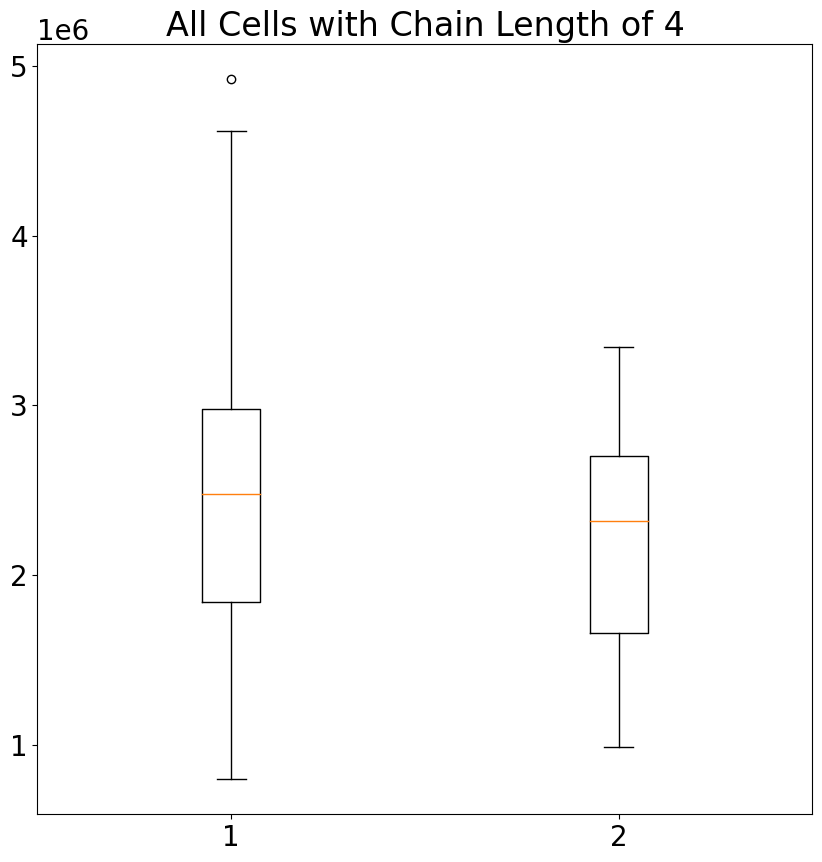

In [7]:
motif_produce_boxplot(all_cells_four_chain_results_array, just_pyramidal = False, chain_num = 4)

A [2948, 3916, 0, 0, 0, 1308, 0, 2089, 440, 0, 621, 8188, 9715, 1338, 6070, 0, 9331, 0, 3595, 0, 524, 0, 2146, 5119, 2605, 0, 0, 2677, 0, 0, 3251, 1141, 7047, 0, 8881, 0, 6204, 0, 984, 291, 0, 3455, 290]
No A [0, 5240, 2277, 0, 0, 1387, 309, 1847, 0, 0, 0, 10776]
Done
Rank-Sum Test: 0.2772682908352456


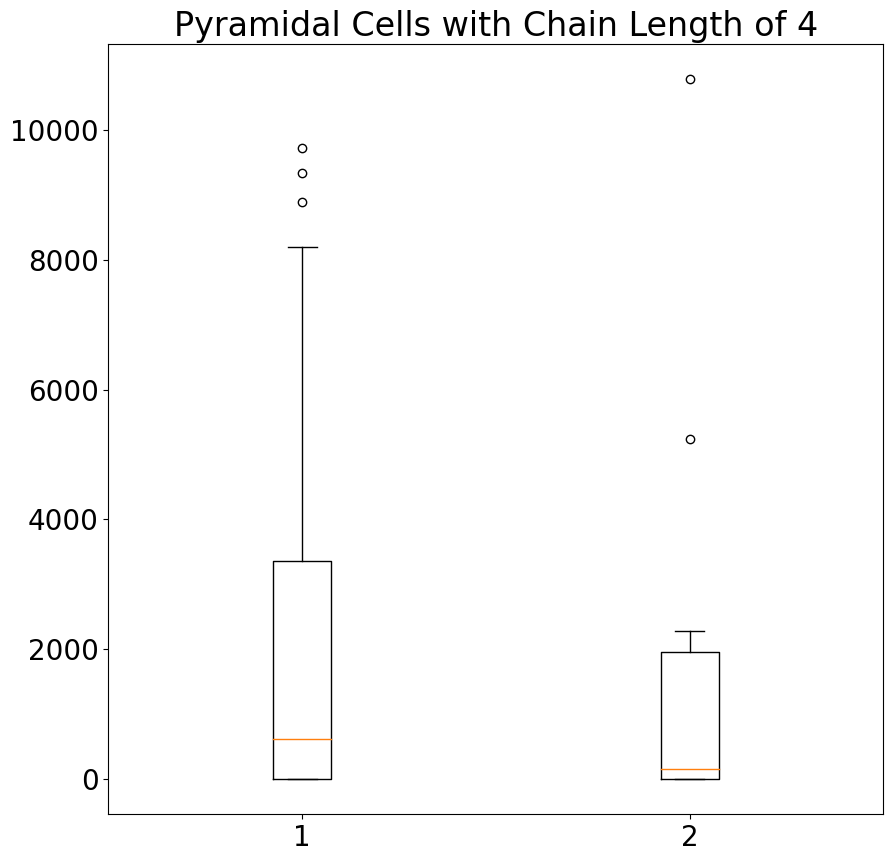

In [8]:
motif_produce_boxplot(pyr_cells_four_chain_results_array, just_pyramidal = True, chain_num = 4)